<a href="https://colab.research.google.com/github/hardikparwana/aerosp_sem3/blob/dh%2FAEROSP567/F21AEROSP567_Proj1_Hanover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1
## Drew Hanover
### AEROSP 567
### Fall 2021

# 2 Warmup: Life without a CLT

In [149]:
pip install pytictoc

In [152]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Sympy Stuff
import sympy as sym
from sympy import erf
from sympy.utilities.lambdify import lambdify
from pytictoc import TicToc


In [ ]:
def monte_carlo(num_samples, sample_generator, g_evaluator, cumsum=False):
    """Perform Monte Carlo sampling
    
    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples
                 
    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:        
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)
        
    return estimate, samples, evaluations

In [ ]:
def pareto(x_input, alpha):
    """ Get value from pareto distribution
    Inputs
    -----
    x_input: array of samples to be evaluated
    alpha: integer, tail index 

    """
    return [(alpha)/(x**(alpha+1.)) if x>=1 else 0 for x in x_input]

In [ ]:
pareto(np.array([1., 2., 3., -3.]), 3/2)

[1.5, 0.2651650429449553, 0.09622504486493763, 0]

Now, in order for us to proceed, we need to build an efficient sampler since we know that the Pareto distribution is not uniform. Therefore, we can proceed using the Inverse CDF Trick \\
The CDF of a Pareto Distribution is given as
\begin{align}
  \int_1^x \frac{\alpha}{x^{\alpha + 1}}dx 
\end{align}

In [ ]:
x = sym.Symbol('x')
alpha = sym.Symbol('alpha')
cdf_sym = sym.integrate(alpha/(x**(alpha+1)), (x, 1, x))
print(cdf_sym)
cdf_sym = cdf_sym.subs(alpha,3./2.).evalf()
func_cdf = lambdify(x, cdf_sym) # convert cdf into a numerical function

Piecewise((1 - x**(-alpha), (alpha > -oo) & (alpha < oo) & Ne(alpha, 0)), (alpha*log(x), True))


We can get the exact value of the integral through numerical integration as a sense check for later since the problem is 1 dimensional, i.e. \\
\begin{align}
E\{X_c\} = \int_X x f_X(x) dx
\end{align}

In [ ]:
int_numeric = sym.integrate(x*(3/2)/(x**(3/2+1.)), (x,1,sym.oo) )
print(int_numeric)

3.00000000000000


Then we can generate a function to evaluate the CDF exactly:

In [ ]:
def pareto_cdf(x_input, alpha):
    """ Calculate CDF of pareto distribution
    Inputs
    -----
    x_input: array of samples to be evaluated
    alpha: integer, tail index 

    Outputs
    -----
    cdf: array
    """
    return 1 - x_input**(-alpha)

Next, we can implement the Inverse CDF Trick to generate samples from the Pareto distribution

In [ ]:
np.random.seed(1337) # set seed for reproducibility

def func_inv(xvals, cdf_vals, u, num_samples):
    """A function to compute the inverse cdf from a discrete set of values
    
    Inputs
    ------
    xvals:    (N, ) array of locations at which cdf_vals is obtained (sorted)
    cdf_vals: (N, ) array of values of the cdf (sorted)
    u: (N, ) array of numbers between 0 and 1, threshold
    num_samples: integer = N
    """
    x_out = []
    for i in range(num_samples):
        index = np.argmax( cdf_vals > u[i] )
        x_out.append( xvals[index] )
    return x_out

Then as a sense check, we can look at the inverse CDF over a series of x values

(10000,)


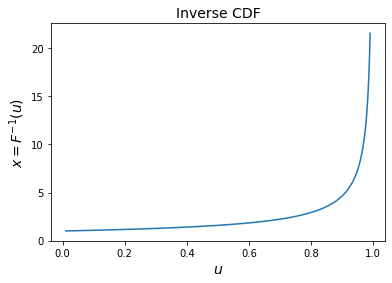

In [ ]:
    xcheck = np.linspace(1, 50, 10000)
    us = np.linspace(0.01, 0.99, 10000)
    print(np.shape(us))
    alpha = 3/2
    # ys = pareto(xcheck,alpha)
    ys = func_cdf(xcheck)
    xs = func_inv(xcheck, ys, us, 10000)

    plt.figure()
    plt.plot(us, xs)
    plt.xlabel(r'$u$', fontsize=14)
    plt.ylabel(r'$x = F^{-1}(u)$', fontsize=14)
    plt.title('Inverse CDF', fontsize=14)
    plt.show()

Then we can finally build the sampler which can be passed to the MC algorithm

In [ ]:
def sampler(ns):
   u = np.random.uniform(size = ns) # generate ns random uniform samples
   return func_inv(xdisc, cdf_disc, u, ns)

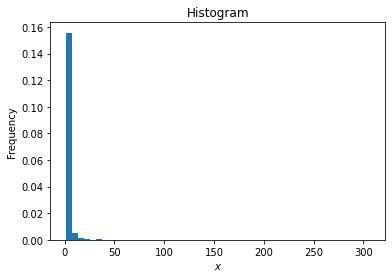

In [ ]:
alpha = 3/2
xdisc = np.linspace(1,1000,10000) # a discretization for easy evaluation of the inverse CDF
cdf_disc = func_cdf(xdisc) # discrete CDF values
nsamples = 10000
# samples = pareto_sampler(nsamples)

# xs = [func_inv(xcheck, ys, u) for u in us]
xs = sampler(nsamples)

plt.figure()
plt.hist(xs, bins=50, density=True)
plt.xlabel(r'$x$')
plt.ylabel('Frequency')
plt.title("Histogram")
plt.show()

And now that we have the sampler, it can be passed through to the MC algorithm

In [ ]:
alpha = 3/2
g = lambda sampled_x:sampled_x#[(alpha)/(x**(alpha+1.)) if x>=1 else 0 for x in sampled_x]
num_samples = 10000
Pz_mc, _, _ = monte_carlo(num_samples, sampler, g)
print("Monte Carlo Estimate with {:d} samples = {:5E}\n\t".format(num_samples, Pz_mc))


Monte Carlo Estimate with 10000 samples = 3.074281E+00
	


Now we can repeat the experiment many times

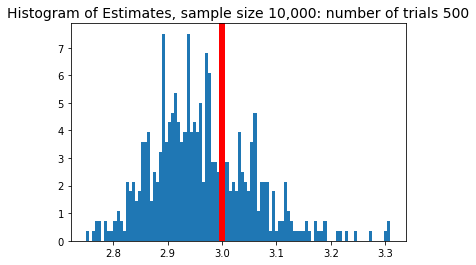

In [ ]:
num_trials = 500
num_samples = 10000
estimates = np.zeros((num_trials))
for ii in range(num_trials):
    estimates[ii], _, _ = monte_carlo(num_samples, sampler, g)

fig, axs = plt.subplots(1)
axs.hist(estimates, bins=100, density=True)
axs.axvline(x=int_numeric, linewidth=6, color='red')

axs.set_title("Histogram of Estimates, sample size 10,000: number of trials 500", fontsize=14)
plt.show()


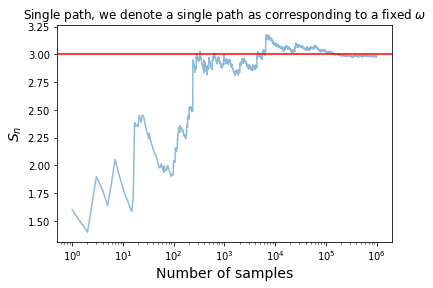

In [ ]:
# Compute a hierarchy of estimates using shared samples from 1 to 1000000
estimate, samples, evaluations = monte_carlo(1000000, sampler, g, cumsum=True)

plt.figure()
nsamples = 1 + np.arange(estimate.shape[0])  # an array of numbers from 1....nsamples
plt.semilogx(nsamples, estimate, alpha=0.5)
plt.axhline(y=int_numeric, color='red', label='True value')
plt.xlabel('Number of samples',fontsize=14)
plt.ylabel(r'$S_n$', fontsize=14)
plt.title(r'Single path, we denote a single path as corresponding to a fixed $\omega$')
plt.show()

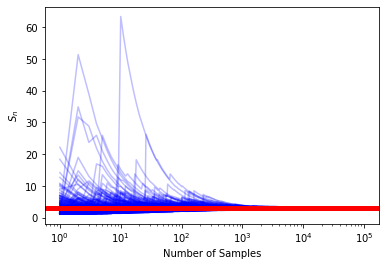

In [ ]:
ntrials = 500
nsamples = 100000
estimate = np.zeros((ntrials, nsamples))
plt.figure()
for ii in range(ntrials):
    estimate, samples, evaluations = monte_carlo(nsamples, sampler, g, cumsum=True)
    estimate_vals[ii, :] = estimate
    plt.semilogx(np.arange(1, nsamples+1), estimate_vals[ii, :], '-', color='blue', alpha=0.25)
plt.axhline(y=int_numeric, color='red', linewidth=5)
plt.xlabel('Number of Samples')
plt.ylabel(r'$S_n$')
plt.show()

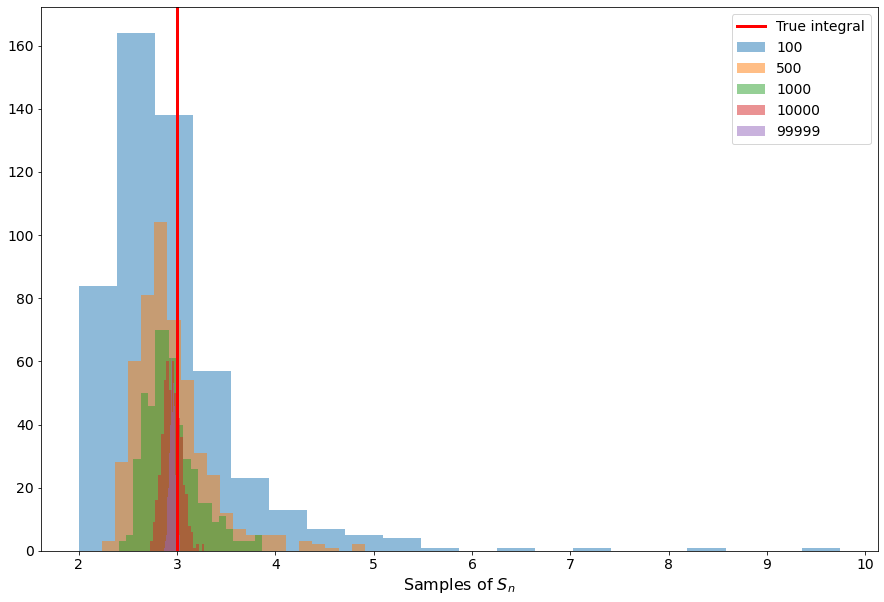

In [ ]:
fixed_n = [100, 500, 1000, 10000, 99999] # Sample set sizes we are investigating
plt.figure(figsize=(15,10))
for n in fixed_n:
    plt.hist(estimate_vals[:, n], bins=20, alpha=0.5, label="{0}".format(n))
plt.axvline(x=int_numeric, color='red', linewidth=3, label='True integral')
plt.xlabel(r'Samples of $S_n$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

# 3 Importance Sampling for Random Walks

## 3.1 1D-Bernoulli Random Walks

In [ ]:

def generate_random_walk_steps(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.5] = 1.0
    X[X < 0.5] = -1.0
    return X


In [ ]:
def simulate_random_walk(num_steps, sampler=generate_random_walk_steps, cum_sum =True):
    steps = sampler(num_steps)
    if cum_sum:
        estimate = np.cumsum(steps, axis=0)
    else:
        estimate = np.sum(steps,axis=0)
    return estimate, steps

In [ ]:
N = 500
NUM_SAMPLES = 100
estimator_values = np.zeros((N,NUM_SAMPLES))
for trial in range(N):
    estimator_values[trial,:], _ = simulate_random_walk(NUM_SAMPLES, generate_random_walk_steps)

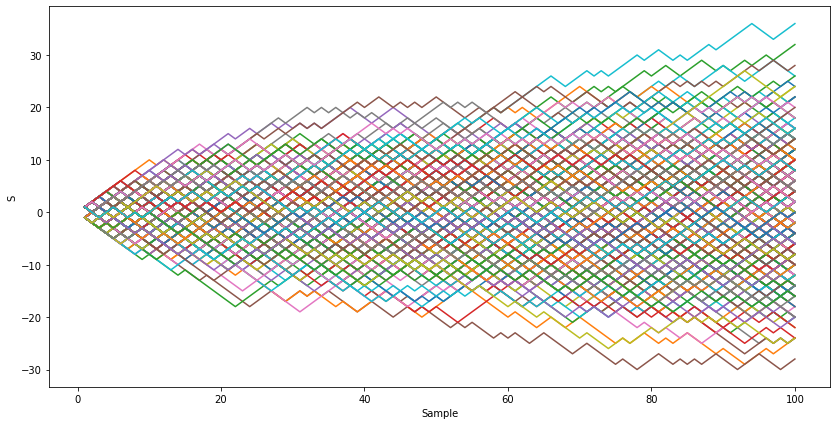

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(np.arange(1,NUM_SAMPLES+1), estimator_values.T)
plt.xlabel(r"Sample")
plt.ylabel("S")
plt.show()

Now we can implement a simple Monte Carlo estimator to compute the probability of $\mathcal{P}(S>10)$

In [ ]:
N = 10**5
estimator_values = np.zeros((N,NUM_SAMPLES))
for trial in range(N):
    estimator_values[trial,:], _ = simulate_random_walk(NUM_SAMPLES, generate_random_walk_steps)


def simpleMC(paths, num_paths, threshold):
    """
    Inputs
    -----
    paths: array of random walks
    num_paths: integer, number of random walks
    threshold: float for probability cutoff
    
    Outputs
    -----
    estimate: float output from MC estimator
    """
    condition = np.any(paths[:,-1:] > threshold, axis=1)
    return np.sum(condition)/num_paths


print("P(S>10) Using MC is ", simpleMC(estimator_values,N,10))
print("P(S>55) Using MC is ", simpleMC(estimator_values,N,55))



P(S>10) Using MC is  0.13457
P(S>55) Using MC is  0.0


So Traditional Monte Carlo fails to provide a good estimate with only 100,000 estimates and Importance Sampling is needed.
Ultimately, we wish to shift the distriubtion such that we have a higher probability of landing a +1 step from the random walk. This will increase the sample density for P(S>55)

In [ ]:
SHIFT_PROBABILITY = 0.1
def generate_shifted_random_walk_steps(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > SHIFT_PROBABILITY] = 1.0
    X[X < SHIFT_PROBABILITY] = -1.0
    return X

In [ ]:
def simulate_weighted_random_walk(num_steps, sampler=generate_shifted_random_walk_steps, cum_sum =True):
    steps = sampler(num_steps)
    weighted_steps = np.asarray([step  * 0.5 / (1-SHIFT_PROBABILITY if step>0 else SHIFT_PROBABILITY) for step in steps])
    if cum_sum:
        estimate = np.cumsum(weighted_steps, axis=0)
    else:
        estimate = np.sum(weighted_steps,axis=0)
    return estimate, steps

As a test, let's check to make sure that the new sampler is implemented properly and generates steps with higher probability of moving +1

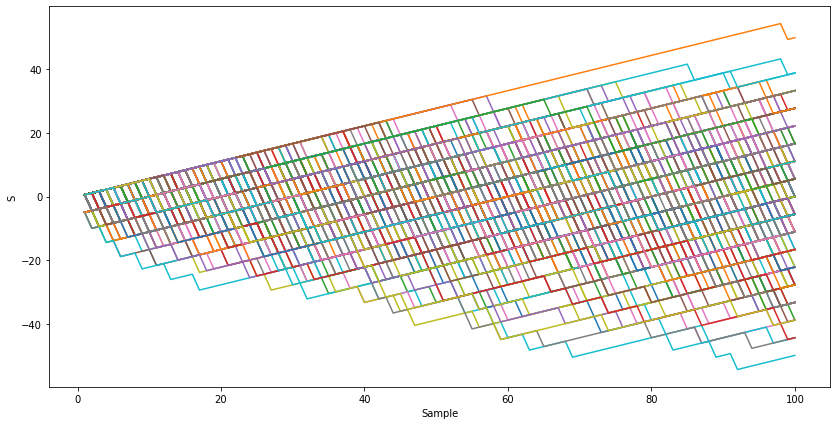

In [ ]:
N = 500
NUM_SAMPLES = 100
estimator_values = np.zeros((N,NUM_SAMPLES))
for trial in range(N):
    estimator_values[trial,:], steps = simulate_weighted_random_walk(NUM_SAMPLES, generate_shifted_random_walk_steps)

plt.figure(figsize=(14,7))
plt.plot(np.arange(1,NUM_SAMPLES+1), estimator_values.T)
plt.xlabel(r"Sample")
plt.ylabel("S")
plt.show()

Looks good, now we can run Monte Carlo

In [ ]:
N = 10**5
NUM_SAMPLES = 100
estimator_values = np.zeros((N,NUM_SAMPLES))
weighted_steps = np.zeros((N,NUM_SAMPLES))

for trial in range(N):
    estimator_values[trial,:], _ = simulate_weighted_random_walk(NUM_SAMPLES, generate_shifted_random_walk_steps, False)

print("P(S>55) Using MC is %.12f" % simpleMC(estimator_values,N,55))


P(S>55) Using MC is 0.000010000000


In [ ]:
def monte_carlo(num_samples, sample_generator, g_evaluator, cumsum=False):
    """Perform Monte Carlo sampling
    
    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples
                 
    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:        
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)
        
    return estimate, samples, evaluations



# The sampler is now from the shifted exponential random variable
gfunc_mc = lambda x: x>55 #
sampler = lambda ns: simulate_weighted_random_walk(NUM_SAMPLES, generate_shifted_random_walk_steps)
#gfunc_is = lambda x: stats.norm.pdf(x) / stats.expon.pdf(x, loc=4.5) 
# The sampler can only generate samples greater than 4.5 so we dont need to multiply by indicator 
# A general version would require 
gfunc_is = lambda x: gfunc_mc(x) * 0.5 / stats.expon.pdf(x, loc=4.5) 

# Now run Monte Carlo with the new sampler and the new random variable
Pz_is, samples, weights = monte_carlo(M, sampler, gfunc_is)

# 4 Multilevel Monte Carlo and Control Variates for Stochastic ODEs

In [ ]:
def brownian_motion_simulate(T, dt, num_paths):
    """Simulate a single path of brownian motion
    
    Inputs
    ------
    T: floating point variable, greater than 0, final time 
    dt: time increment of the simulation
    
    Returns
    -------
    bmotion: single path of a brownian motion simulation (nsamples, npaths)
    """
    nsamples = int(np.ceil(T / dt)) + 1
    samples = np.random.randn(nsamples, num_paths) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples, axis=0)
    return bmotion

def brownian_motion_fine_to_coarse(T, dt, brownian_fine, M):
    """Extract a sample of a coarse brownian motion simulation from a fine brownian motion simulation"""
    
    nsamples = int(np.ceil(T/dt)) + 1
    npaths = brownian_fine.shape[1]
    brownian_coarse = np.zeros((nsamples, npaths))
    brownian_coarse[0, :] = brownian_fine[0, :]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M, :] - brownian_fine[(ii-1)*M, :]
        brownian_coarse[ii, :] = brownian_coarse[ii-1, :] + delta
    return brownian_coarse

def euler_maruyama(b, h, x0, dt, T, bmotion):
    """Perform Euler Maruyama integration to integrate a one dimensional SDE
        
        dX = b(t, X) dt + h(t, X) dW
    
    Inputs
    ------
    b: function taking input of a single time and a vector of (Npaths) values X
    h: function taking input of a single time and a vector of (Npaths) values X
    x0: initial condition (Npaths, )
    dt: time step
    T: final time
    bmotion: a brownian motion simulation (Nsteps, Npaths) that is consistent with dt and T
    
    Returns
    -------
    times: time incrememnts
    paths: (Nsteps, npaths)
    """
    
    num_paths = x0.shape[0]
    assert bmotion.shape[1] >= num_paths, "Not enough brownian motions simulated"
    num_steps = int(np.ceil(T / dt)) + 1
    paths = np.zeros((num_steps, num_paths))
    paths[0, :] = x0
    times = np.zeros(num_steps)
    t = 0
    for ii in range(1, num_steps):
        paths[ii, :] = paths[ii-1, :] + b(t, paths[ii-1, :]) * dt + h(t, paths[ii-1, :]) * (bmotion[ii, :] - bmotion[ii-1, :])
        t += dt
        times[ii] = t;
    return times, paths

Define the Process

In [ ]:
mu = 0.2
sigma = 0.05
ou_bfunc = lambda t, y: -mu * y
ou_hfunc = lambda t, y: sigma * np.ones(y.shape)

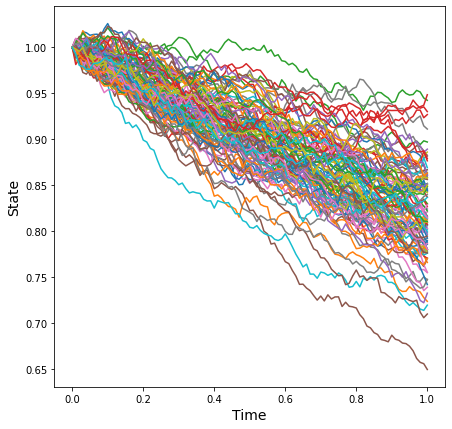

In [ ]:
def sim_and_plot(num_paths=20):
    
    T = 1
    dt = 1e-2
    bmotion = brownian_motion_simulate(T, dt, num_paths)
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    
    plt.figure(figsize=(7, 7))
    plt.plot(times, states)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('State', fontsize=14)
    plt.show()
sim_and_plot(num_paths=100)

Standard MC took 0.009441 seconds.
Monte Carlo Estimate is [0.91573883]
Estimated Monte Carlo Standard Error is 0.0008510784565646154


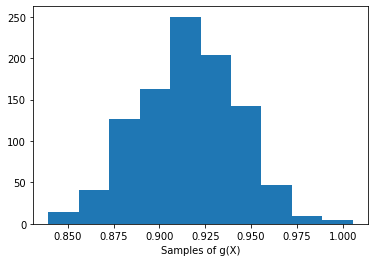

In [157]:
def evaluator(bmotion, dt, T):
    """ Evaluate an approximate integral of a path of the OU process"""
    
    num_paths = bmotion.shape[1]
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    res = np.sum(states, axis=0) * dt
    res = res[:, np.newaxis] # make this an N x 1 array, which is what we need for the monte carlo function
    return res

def sampler(nsamples, dt, T):
    """ Generate samples of the brownian motion"""
    bmotion = brownian_motion_simulate(T, dt, nsamples)
    return bmotion

nsamples = 1000
dt = 1e-2
T = 1
g = lambda X: evaluator(X, dt, T)
s = lambda N: sampler(N, dt, T)
MC_timer = TicToc()
MC_timer.tic()
estimate, samples, evals = monte_carlo(nsamples, s, g)
MC_timer.toc('Standard MC took')
plt.figure()
plt.hist(evals)
plt.xlabel("Samples of g(X)")
print("Monte Carlo Estimate is {0}".format(estimate))
print("Estimated Monte Carlo Standard Error is {0}".format(np.sqrt(np.var(evals))/np.sqrt(nsamples)))

Now simulate 2 processes with different dt's

In [ ]:
M = 4
DT = 0.01  # fine scale time step
DTM = DT * M # coarse scale time step
TFINAL = 1.0 # final time
TSPAN_COARSE = np.arange(0, TFINAL + DTM, DTM)
TSPAN_FINE = np.arange(0, TFINAL+DT, DT)
brownian_fine = brownian_motion_simulate(TFINAL, DT,1)
brownian_coarse = brownian_motion_fine_to_coarse(TFINAL, DTM, brownian_fine, M)

times_fine, states_fine = euler_maruyama(ou_bfunc, ou_hfunc, x0, DT, TFINAL, brownian_fine)
times_coarse, states_coarse = euler_maruyama(ou_bfunc, ou_hfunc, x0, DTM, TFINAL, brownian_coarse)



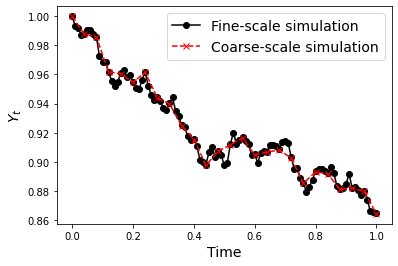

In [ ]:
plt.figure()
plt.plot(times_fine, states_fine, '-ko', label='Fine-scale simulation')
plt.plot(times_coarse, states_coarse, '--rx', label='Coarse-scale simulation')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$Y_t$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Now do MLMC with 4 different levels

In [145]:
def multilevel_montecarlo_sde(func, nsamples, T, M):
    """Multilevel Monte Carlo for Stochastic differential equations"""
    
    ###########################
    # level 0 Only coarse grid evaluations are used
    ###########################
    bmotion_level_0 = brownian_motion_simulate(T, 4**-1, nsamples)
    samples_level_0 = func(bmotion_level_0, 4**-1, T)
    #####################
    # level 1
    ######################
    # First generate fine and coaprse bmotion samples
    bmotion_level_1_fine = brownian_motion_simulate(T, 4**-2, nsamples)
    bmotion_level_1_coarse = brownian_motion_fine_to_coarse(T, 4**-1, bmotion_level_1_fine, M)
        
    # Next evaluate the samples
    samples_level_1_fine = func(bmotion_level_1_fine, 4**-2, T)
    samples_level_1_coarse = func(bmotion_level_1_coarse, 4**-1, T)

    # Now subtract
    samples_delta_level_1 = samples_level_1_fine - samples_level_1_coarse

    #####################
    # level 2
    ######################
    # First generate fine and coaprse bmotion samples
    bmotion_level_2_fine = brownian_motion_simulate(T, 4**-3, nsamples)
    bmotion_level_2_coarse = brownian_motion_fine_to_coarse(T, 4**-2, bmotion_level_2_fine, M)
        
    # Next evaluate the samples
    samples_level_2_fine = func(bmotion_level_2_fine, 4**-3, T)
    samples_level_2_coarse = func(bmotion_level_2_coarse, 4**-2, T)

    # Now subtract
    samples_delta_level_2 = samples_level_2_fine - samples_level_2_coarse

    #####################
    # level 3
    ######################
    # First generate fine and coaprse bmotion samples
    bmotion_level_3_fine = brownian_motion_simulate(T, 4**-4, nsamples)
    bmotion_level_3_coarse = brownian_motion_fine_to_coarse(T, 4**-3, bmotion_level_3_fine, M)
        
    # Next evaluate the samples
    samples_level_3_fine = func(bmotion_level_3_fine, 4**-4, T)
    samples_level_3_coarse = func(bmotion_level_3_coarse, 4**-3, T)

    # Now subtract
    samples_delta_level_3 = samples_level_3_fine - samples_level_3_coarse

    #####################
    # level 4
    ######################
    # First generate fine and coaprse bmotion samples
    bmotion_level_4_fine = brownian_motion_simulate(T, 4**-5, nsamples)
    bmotion_level_4_coarse = brownian_motion_fine_to_coarse(T, 4**-4, bmotion_level_4_fine, M)
        
    # Next evaluate the samples
    samples_level_4_fine = func(bmotion_level_4_fine, 4**-5, T)
    samples_level_4_coarse = func(bmotion_level_4_coarse, 4**-4, T)

    # Now subtract
    samples_delta_level_4 = samples_level_4_fine - samples_level_4_coarse

    
    #####################
    ## Combine levels
    #####################
    est_mean = np.mean(samples_level_0) + np.mean(samples_delta_level_1) + np.mean(samples_delta_level_2) + np.mean(samples_delta_level_3) + np.mean(samples_delta_level_4)
    est_var_levels = np.array([np.var(samples_level_0), np.var(samples_level_1_coarse), np.var(samples_level_2_coarse), np.var(samples_level_3_coarse), np.var(samples_level_4_coarse,)])
    est_mean_levels = np.array([np.mean(samples_level_0), np.mean(samples_level_1_coarse), np.mean(samples_level_2_coarse), np.mean(samples_level_3_coarse), np.mean(samples_level_4_coarse)])
    est_var_discrepancy_levels = np.array([np.var(samples_level_0),  np.var(samples_delta_level_1), np.var(samples_delta_level_2), np.var(samples_delta_level_3), np.var(samples_delta_level_4)])

    return est_mean, est_var_levels, est_mean_levels, est_var_discrepancy_levels

In [155]:
dt = 4**-5 # fine
T = 1.0
M = 4 # coarse scale
nsamples = 1000
MLMC_timer = TicToc()
MLMC_timer.tic()
est_mlmc, est_var_levels, est_mean_levels, est_var_discrep = multilevel_montecarlo_sde(evaluator, nsamples, T, M)
print("MLMC Estimate is {0}".format(est_mlmc))
MLMC_timer.toc("MLMC took")



MLMC Estimate is 0.9072990843933044
MLMC took 0.123053 seconds.


Now we plot the Variances and Discrepancies at each level

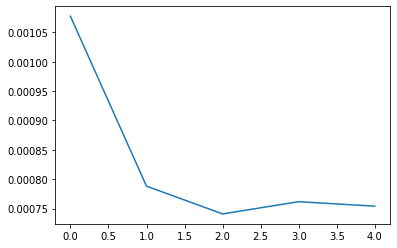

In [138]:
plt.figure()
plt.plot(est_var_levels)

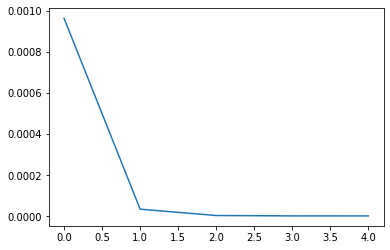

In [143]:
plt.figure()
plt.plot(est_var_discrep)

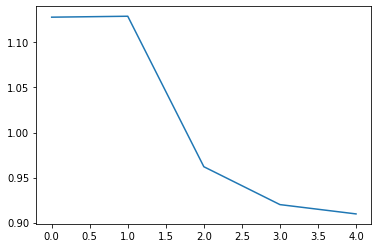

In [147]:
plt.figure()
plt.plot(est_mean_levels)

It goes down with each level, great